# RoPE

正余弦编码的问题在于将绝对位置信息编码成了固定的向量，这种做法导致注意力`q*k`的计算中如果是高维度的情况下，对短距离的位置变化不敏感，导致模型在长序列任务里分不清细节

假设在一个`seq_len=100`的序列中，两个词向量的位置pos分别是m和n，那么相对距离就是`m-n`，RoPE的目标就是在位置编码的时候引入`m-n`这一相对位置信息
> 找到一种映射$g$，针对两个注意力的向量$q$和$k$，使得
>
> $f(q, m)f(k, n) = g(q, k, m-n)$

# 二维向量的旋转操作

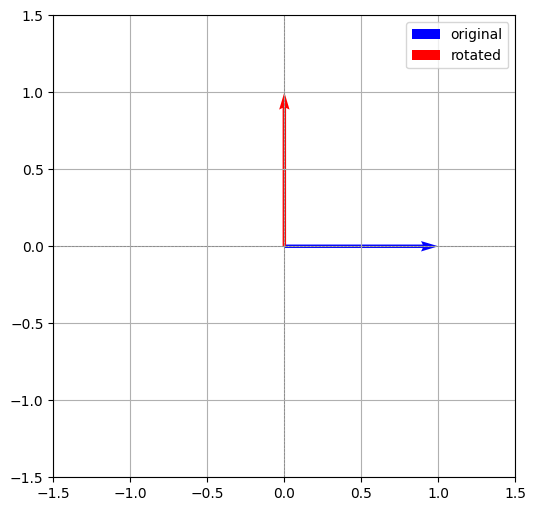

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_2d(x, y, theta_rad):
    R = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)]
    ])
    vec = np.array([x, y])
    # @是矩阵点乘，*是逐元素乘法
    return R @ vec

# Example usage
x0, y0 = 1, 0

# 旋转角度
theta_deg = 90
theta_rad = np.deg2rad(theta_deg) # 角度转弧度，np.cos和np.sin默认都是使用弧度制，如果写np.cos(90)会被认为是90弧度

# 旋转后向量
x1, y1 = rotate_2d(x0, y0, theta_rad)

# 可视化
plt.figure(figsize=(6, 6))
plt.quiver(0, 0, x0, y0, angles="xy", scale_units="xy", scale=1, color="blue", label="original") # 绘制二维向量（箭头）
plt.quiver(0, 0, x1, y1, angles="xy", scale_units="xy", scale=1, color="red", label="rotated") # angle表示角度计算方式，scale_unit是缩放单位，scale是缩放比例

# 坐标轴设置
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect("equal") # 获取当前坐标轴对象, 坐标轴等比例
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5) # 绘制水平 / 垂直参考线
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.grid(True)
plt.legend()

plt.show()

# RoPE的工作原理

模型维度：$d_{\text{model}} = 2$ \
原始向量： $ \mathbf{q} = \begin{bmatrix} 1 \ 2 \end{bmatrix}, \quad \mathbf{k} = \begin{bmatrix} 3 \ 4 \end{bmatrix} $ \
序列位置：设为 $\text{pos}_q = m$, $\text{pos}_k = n$ \
对应位置角频率为 $\theta = \omega \cdot \text{pos}$, 其中 $\omega$ 是一个频率超参数

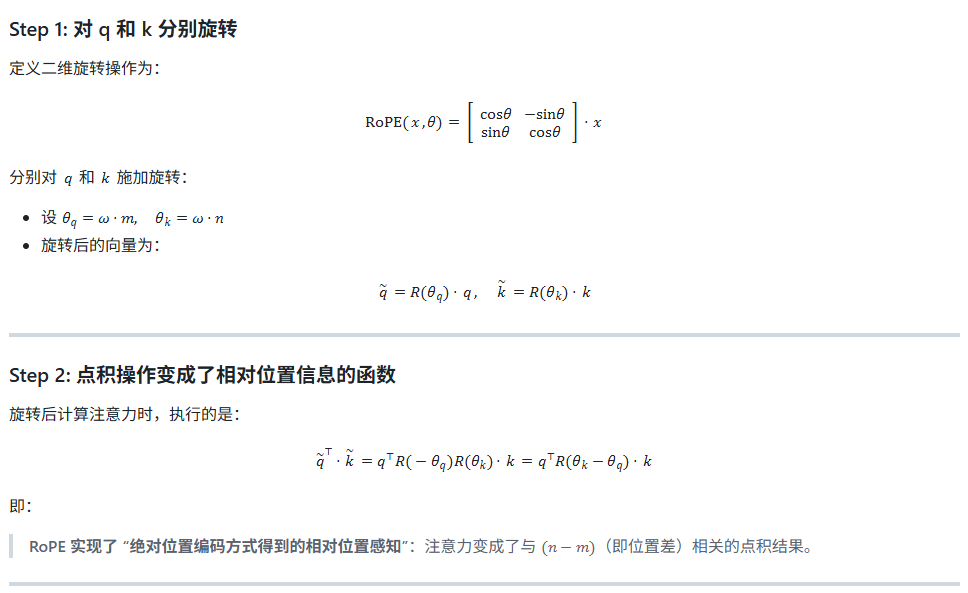

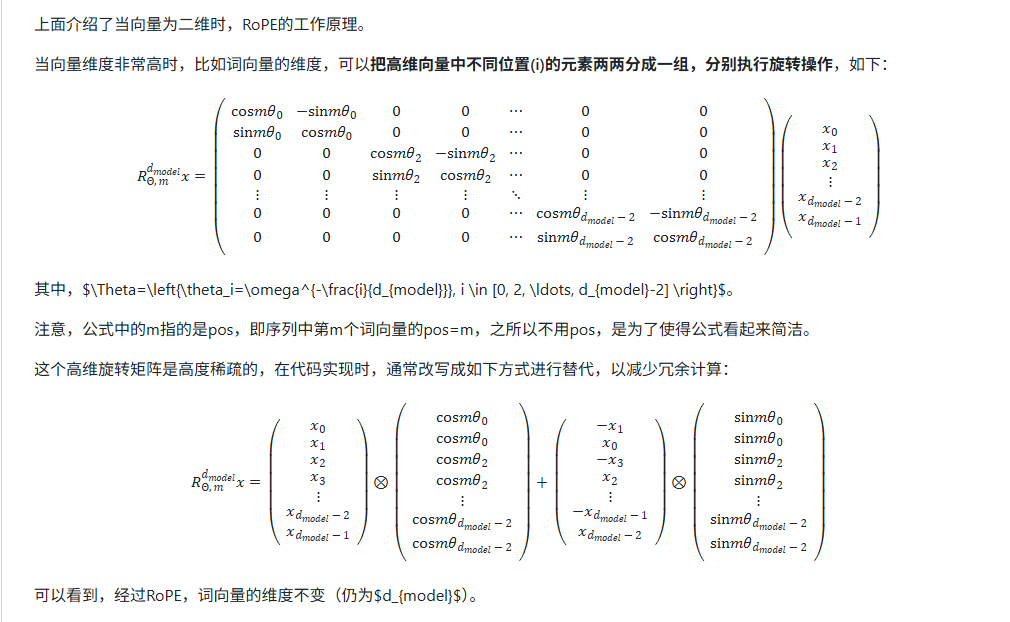

<span style="color: red;">注意，公式中的m指的是pos，即序列中第m个词向量的pos=m</span>

$\Theta = \left\{ \theta_i = \omega^{-\frac{i}{d_{\text{model}}}}, \ i \in [0, 2, \dots, d_{\text{model}} - 2] \right\}$

$ \begin{bmatrix} \cos(2) & -\sin(2) \ \sin(2) & \cos(2) \end{bmatrix} \cdot \begin{bmatrix} 1 \ 0 \end{bmatrix} \begin{bmatrix} \cos(2) \ \sin(2) \end{bmatrix} \approx \begin{bmatrix} -0.4161 \ 0.9093 \end{bmatrix} $

$ \begin{bmatrix} \cos(0.02) & -\sin(0.02) \ \sin(0.02) & \cos(0.02) \end{bmatrix} \cdot \begin{bmatrix} 0 \ 1 \end{bmatrix}
\begin{bmatrix} -\sin(0.02) \ \cos(0.02) \end{bmatrix} \approx \begin{bmatrix} -0.02 \ 0.9998 \end{bmatrix} $

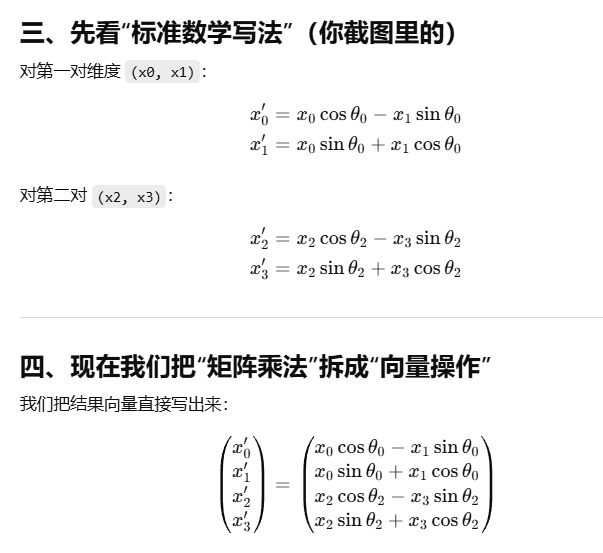
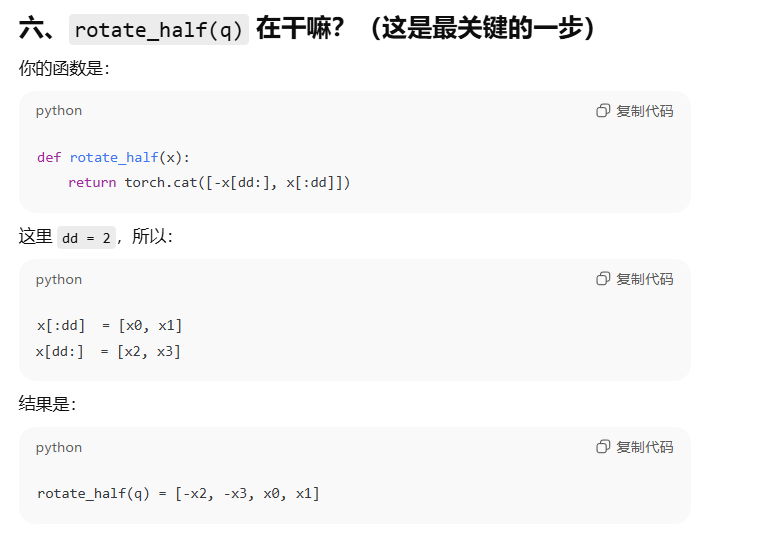
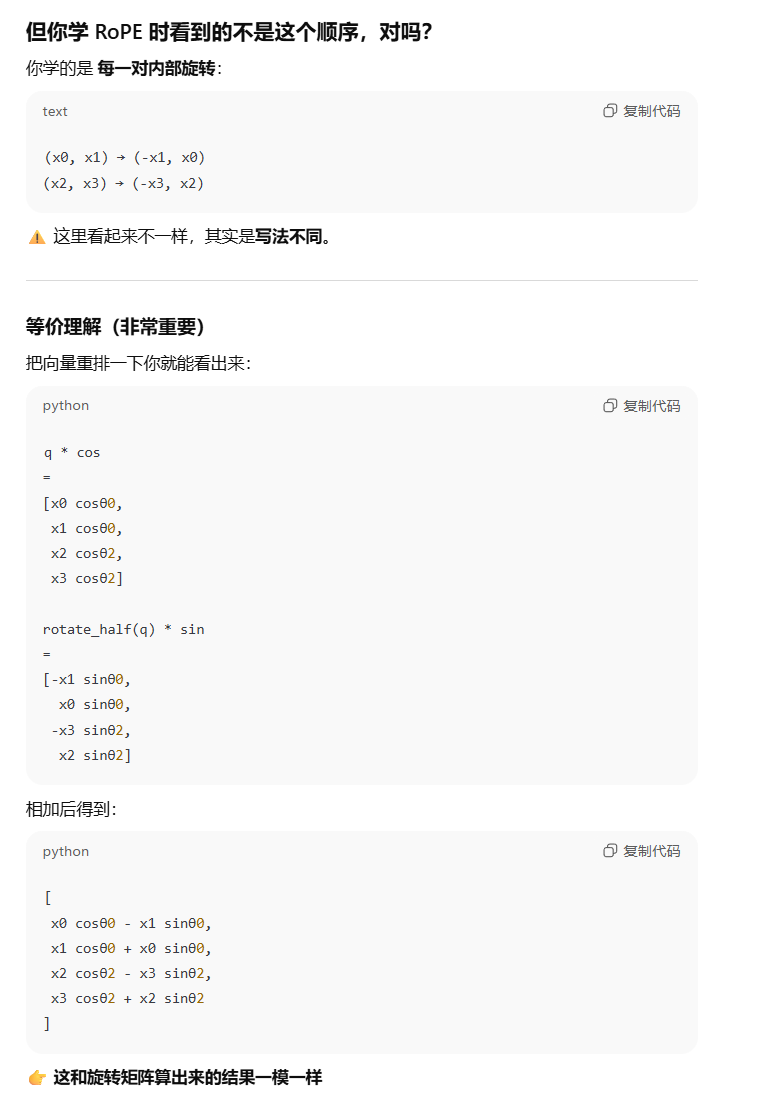

In [7]:
import torch

d_model = 4 # 嵌入维度
dd = d_model // 2 # 一半维度
omiga = 10000.0
m = 2 # pos

freqs = 1.0 / (omiga ** (torch.arange(0, d_model, 2).float() / d_model)) # 频率
angles = m * freqs

q = torch.tensor([1.0, 0.0, 0.0, 1.0]) # 查询向量

cos = torch.cat([torch.cos(angles), torch.cos(angles)])
sin = torch.cat([torch.sin(angles), torch.sin(angles)])

def rotate_half(x):
    return torch.cat([-x[dd:], x[:dd]])

q_embed = q * cos + rotate_half(q) * sin
print(q_embed)

tensor([-0.4161, -0.0200,  0.9093,  0.9998])


# 代码实现MiniMind里的RoPE

In [10]:
def precompute_freqs_cis(d_model: int, end: int=int(32*1024), omiga: float=1e6):
    # d_model 嵌入维度
    # end 预计最大序列长度
    # omiga 频率基数
    freqs = 1.0 / (omiga ** (torch.arange(0, d_model, 2)[:(d_model // 2)].float() / d_model)) # 算频率omiga
    t = torch.arange(end, device=freqs.device) # 生成pos序列
    freqs = torch.outer(t, freqs).float() # 外积
    freqs_cos = torch.cat([torch.cos(freqs), torch.cos(freqs)], dim=-1)
    freqs_sin = torch.cat([torch.sin(freqs), torch.sin(freqs)], dim=-1)
    return freqs_cos, freqs_sin

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    def rotate_half(x):
        # [x0, x1, x2, x3] -> [-x2, -x3, x0, x1]
        return torch.cat((-x[..., x.shape[-1] // 2:], x[..., :x.shape[-1]//2]), dim=-1)

    q_embed = (q * cos.unsqueeze(unsqueeze_dim)) + (rotate_half(q) * sin.unsqueeze(unsqueeze_dim)) # 在指定unsqueeze_dim的位置插入1个新的维度
    k_embed = (k * cos.unsqueeze(unsqueeze_dim)) + (rotate_half(k) * sin.unsqueeze(unsqueeze_dim))
    return q_embed, k_embed

d_model = 4
q = torch.tensor([1, 2, 3, 4])
k = torch.tensor([5, 6, 7, 8])

freq_cos, freq_sin = precompute_freqs_cis(d_model)
q_embed, k_embed = apply_rotary_pos_emb(q, k, freq_cos, freq_sin)
print(q_embed.shape, k_embed.shape)

torch.Size([32768, 1, 4]) torch.Size([32768, 1, 4])
